### Use case 2 📊🗺️
## Unexpected melting of Öskjuvatn, Iceland

<img src="images/AskjaVulcano.jpg" alt="Drawing" style="width: 600px;"/>

This notebook demonstrates how ARLIE data can be used to study an unexpected melting event in the volcanic lake Öskjuvatn. Located in the crater of the active volcano Askja in the central highlands of Iceland, the lake usually stays frozen until June or July. Yet, in February 2023, Copernicus Sentinel-2 satellite images revealed an early melting of the lake. The actual reason behind the melting event is not fully clarified but likely due to increased geothermal activity of the Askja vulcano.

In this notebook, we will cover the following steps:
 1) Retrieve and organise ARLIE data for Lake Öskjuvatn
 2) Sanity check data and filter noisy observations
 3) Analyse time series for Lake Öskjuvatn

### 1) Retrieve and organise ARLIE data for Lake Öskjuvatn

In [1]:
# Import the API to download ARLIE data
from clms_hrsi_arlie_downloader import download_arlie_products

# Lake Öskjuvatn is defined by the following polygon in wkt format
geometryWkt = 'POLYGON ((-16.813032 65.012446, -16.813032 65.048888, -16.675698 65.048888, -16.675698 65.012446, -16.813032 65.012446))'

# Set the remaining variables to retrieve ARLIE data for the years 2017-2023  
outputDir = "use-case-2/output"
startDate = '2019-01-01'
completionDate = '2024-01-01'
cloudCoverageMax = 100
requestGeometries = True
returnMode = 'csv_and_variable'

geom, arlie = download_arlie_products(returnMode, outputDir=outputDir, startDate=startDate, completionDate=completionDate, geometryWkt=geometryWkt, cloudCoverageMax=cloudCoverageMax, requestGeometries=requestGeometries)

Executing request for geometries: https://cryo.land.copernicus.eu/arlie/get_geometries?geometrywkt=POLYGON+((-16.813032+65.012446%2C+-16.813032+65.048888%2C+-16.675698+65.048888%2C+-16.675698+65.012446%2C+-16.813032+65.012446))&getonlyids=True
Executing request for geometries: https://cryo.land.copernicus.eu/arlie/get_geometries?geometrywkt=POLYGON+((-16.813032+65.012446%2C+-16.813032+65.048888%2C+-16.675698+65.048888%2C+-16.675698+65.012446%2C+-16.813032+65.012446))
Writing geometries in /home/jovyan/Arlie_repoEL/use-case-2/output/geometries.csv
Executing request for ARLIE: https://cryo.land.copernicus.eu/arlie/get_arlie?geometrywkt=POLYGON+((-16.813032+65.012446%2C+-16.813032+65.048888%2C+-16.675698+65.048888%2C+-16.675698+65.012446%2C+-16.813032+65.012446))&cloudcoveragemax=100&startdate=2019-01-01&completiondate=2024-01-01
Done
Writing ARLIE in /home/jovyan/Arlie_repoEL/use-case-2/output/arlie.csv
Found 1075 ARLIE products.
Writing metadata link into /home/jovyan/Arlie_repoEL/use-c

In [2]:
# Import relevant libraries
import os
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads
from datetime import datetime

In [3]:
# Parse the orignial ARLIE date format to something more readable
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S')

# Read ARLIE data from CSV file into a DataFrame
arlie = pd.read_csv(os.path.join(outputDir, 'arlie.csv'), parse_dates=['datetime'], delimiter=";")

# Add extra columns for year and month
arlie['year'] = arlie['datetime'].dt.year
arlie['month'] = arlie['datetime'].dt.month

# Display the first 5 rows of the DataFrame
arlie.head()

,id,river_km_id,datetime,water_perc,ice_perc,other_perc,cloud_perc,nd_perc,qc,source,year,month
0,1,117263,2019-01-01 07:42:12,98,2,0,0,0,2,Sentinel-1,2019,1
1,2,117263,2019-01-02 07:33:09,98,2,0,0,0,2,Sentinel-1,2019,1
2,3,117263,2019-01-03 18:43:05,99,1,0,0,0,2,Sentinel-1,2019,1
3,4,117263,2019-01-04 18:34:18,99,1,0,0,0,2,Sentinel-1,2019,1
4,5,117263,2019-01-07 07:41:19,98,2,0,0,0,2,Sentinel-1,2019,1


In [6]:
# Read EU Hydro geometries from CSV file
geometries = pd.read_csv('use-case-2/output/geometries.csv', delimiter=";", encoding="utf-8")
geometries['geometry'] = geometries['geometry'].apply(loads)

# Add the geometries to a GeoDataFrame
geometries = gpd.GeoDataFrame(geometries, geometry='geometry', crs='EPSG:3035')

# Display the GeoDataFrame
geometries

,id,geometry,basin_name,eu_hydro_id,object_nam,area,river_km
0,117263,"MULTIPOLYGON (((3090294.034 4900039.749, 30903...",Iceland,NaN,Öskjuvatn,11776296.22,NaN


### 2) Sanity check data and filter noisy observations
It is always a good idea to plot the data and examine how the values are distributed. Thereby, it is possible to see if there is anything unexpected in the data.

In [7]:
# Import relevant libraries
import matplotlib
from matplotlib import pyplot as plt

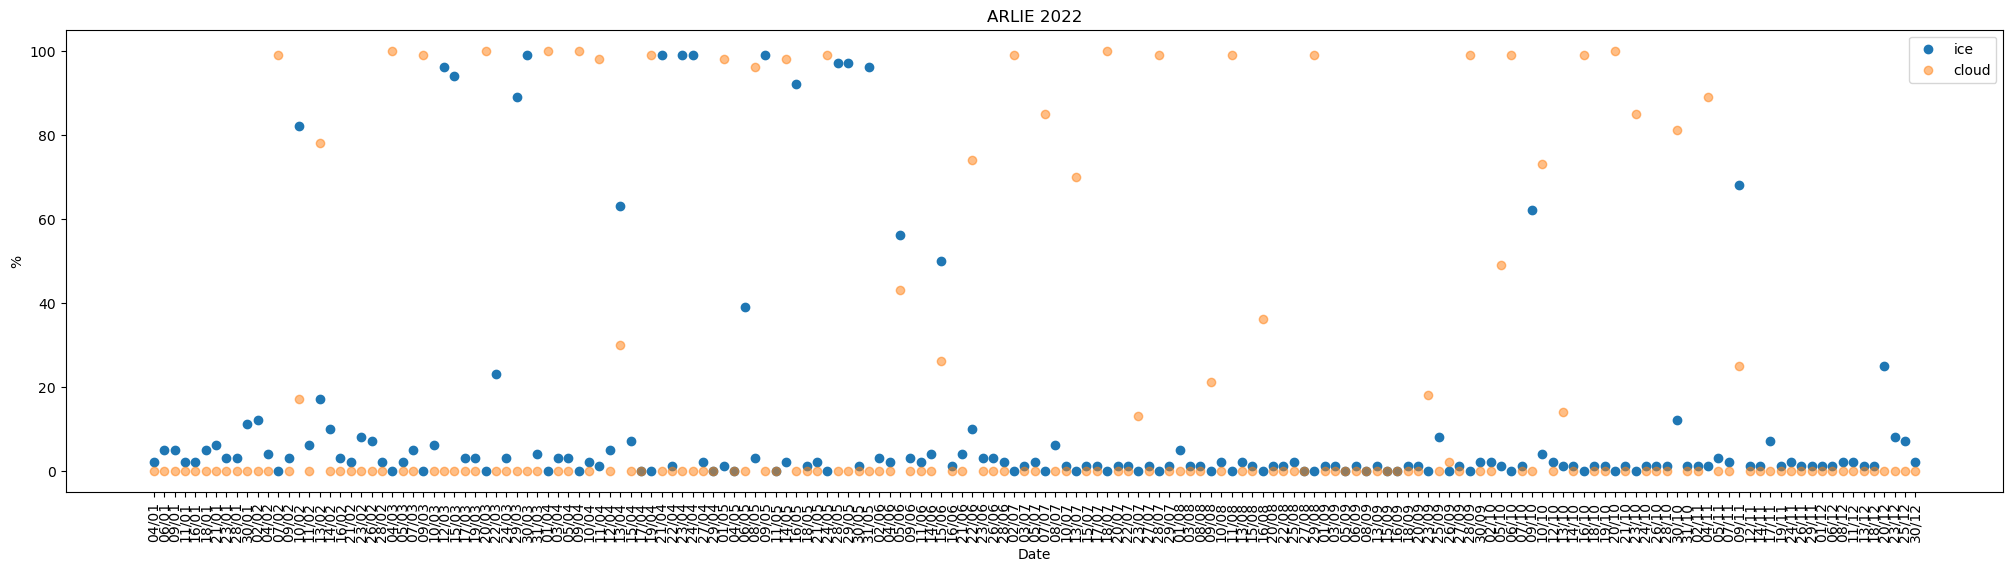

In [8]:
# Take a subset of one year of ARLIE data
subset_2022 = arlie[arlie['year'] == 2022]

# Make a plot of the columns 'ice_perc' and 'cloud_perc' per day
plt.figure(figsize=(25, 6))
plt.scatter(subset_2022['datetime'].dt.strftime('%d/%m'),subset_2022['ice_perc'], label='ice')
plt.scatter(subset_2022['datetime'].dt.strftime('%d/%m'),subset_2022['cloud_perc'], label='cloud', alpha=0.5)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.legend(loc='upper right')
plt.title('ARLIE 2022')
plt.ylabel('%')
plt.show()

As you might have noticed, the ARLIE data for our AOI in Iceland looks a bit noisy. There are quite a few observations with a very low ice cover, where we actually would expect more ice. At the same time, we can observe a high cloud cover on many days.

Clouds and shadows often introduce disturbances in satellite-derived products, and they might be contributing to the noise here. To address this, we plan to clean up the data using the 'qc' (quality check) and 'cloud_perc' (cloud percentage) columns. It's worth mentioning that a thorough validation of values would typically involve examining visual images like Sentinel-2 data. However, for simplicity in this use case, we'll take a straightforward approach by removing observations with very cloudy conditions and low quality.

In [9]:
# Remove data with a value above 70 for cloud_perc and 2 for qc (keep only medium-high quality data)
clean_arlie= arlie[arlie['cloud_perc'] < 70]
clean_arlie= clean_arlie[clean_arlie['qc'] != 2]
clean_arlie.head()

,id,river_km_id,datetime,water_perc,ice_perc,other_perc,cloud_perc,nd_perc,qc,source,year,month
20,21,117263,2019-02-03 12:43:51,0,47,5,48,0,1,Sentinel-2,2019,2
27,28,117263,2019-02-14 13:04:04,0,78,3,18,1,0,Sentinel-2,2019,2
29,30,117263,2019-02-18 18:59:24,57,43,0,0,0,1,Sentinel-1 Sentinel-2,2019,2
30,31,117263,2019-02-19 18:50:36,26,74,0,0,0,0,Sentinel-1 Sentinel-2,2019,2
32,33,117263,2019-02-21 18:34:17,0,99,1,0,0,0,Sentinel-1 Sentinel-2,2019,2


In [10]:
# To check how many observations were removed, print the length before and after applying the thresholds
print("ARLIE observations before cleaning: ", len(arlie))
print("ARLIE observations after cleaning:   ",len(clean_arlie))

ARLIE observations before cleaning:  1075
ARLIE observations after cleaning:    186


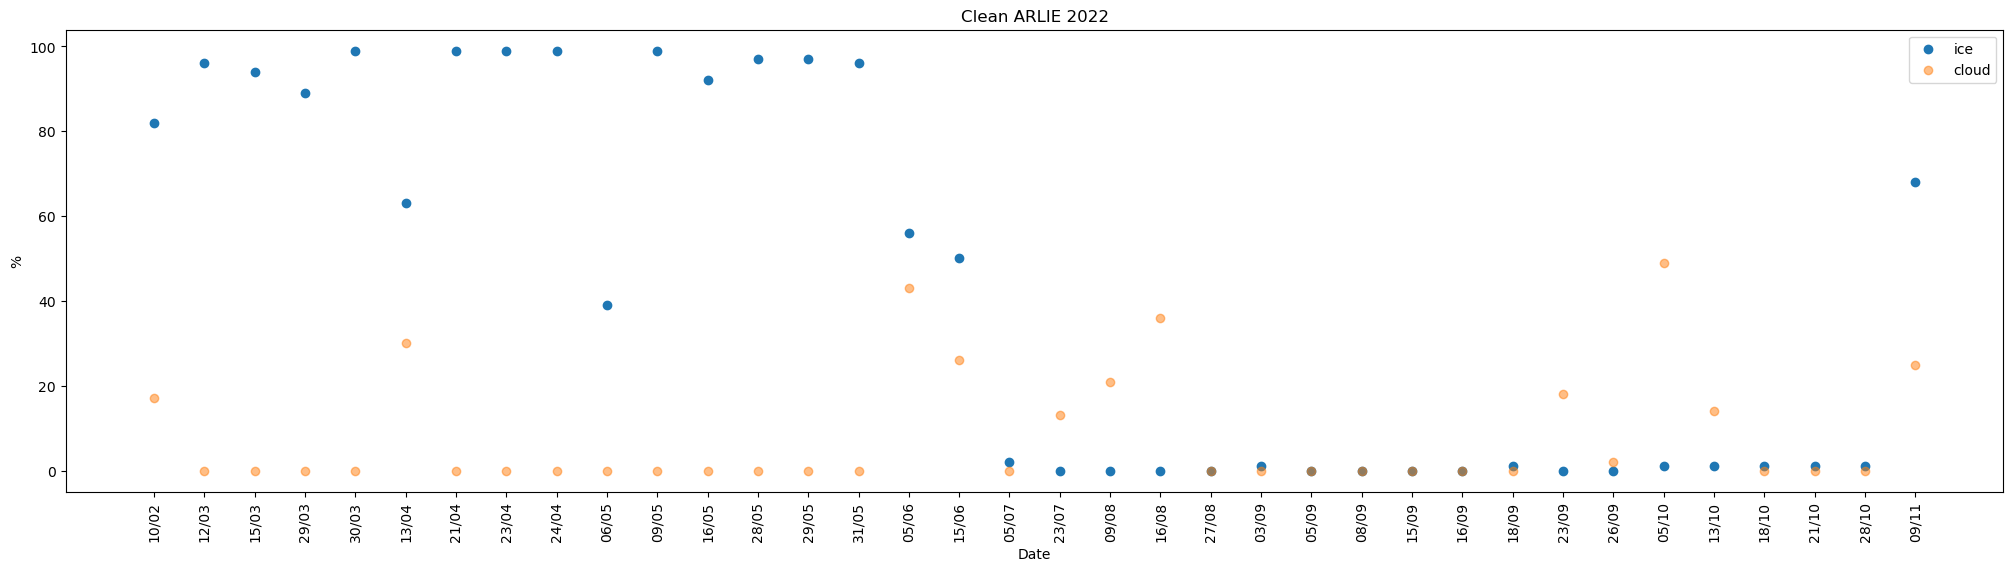

In [11]:
# Take a subset of 2022 cleaned ARLIE data
clean_subset_2022 = clean_arlie[clean_arlie['year'] == 2022]

# Make a plot of the columns 'ice_perc' and 'cloud_perc' per day
plt.figure(figsize=(25, 6))

plt.scatter(clean_subset_2022['datetime'].dt.strftime('%d/%m'),clean_subset_2022['ice_perc'], label='ice')
plt.scatter(clean_subset_2022['datetime'].dt.strftime('%d/%m'),clean_subset_2022['cloud_perc'], label='cloud', alpha=0.5)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.title('Clean ARLIE 2022')
plt.legend(loc='upper right')
plt.ylabel('%')
plt.show()

Great, the data look much better after removing noisy observations! 🧼 <br>
Keep in mind that selecting an appropriate threshold is always depending on the geographic location, specific year and season.

### 3) Analyse time series for Lake Öskjuvatn
Having cleaned up the data, we can calculate simple statistics as for example mean, median, maximum and minimum values. Like this, we can examine how the ice cover of the lake is changing within and in between years.

In [12]:
# Import relevant libraries
import calendar
import random
from matplotlib.cm import get_cmap
import contextily as ctx

In [13]:
# Calculate statistics for each year
years_stats = clean_arlie.groupby('year')['ice_perc'].agg(['mean', 'median', 'max', 'min']).reset_index()
years_stats.columns = ['Year', 'Mean', 'Median', 'Max', 'Min']
years_stats

,Year,Mean,Median,Max,Min
0,2019,41.769231,43.0,100,0
1,2020,31.052632,1.0,99,0
2,2021,36.136364,19.0,100,0
3,2022,42.305556,20.5,99,0
4,2023,24.448276,1.0,99,0


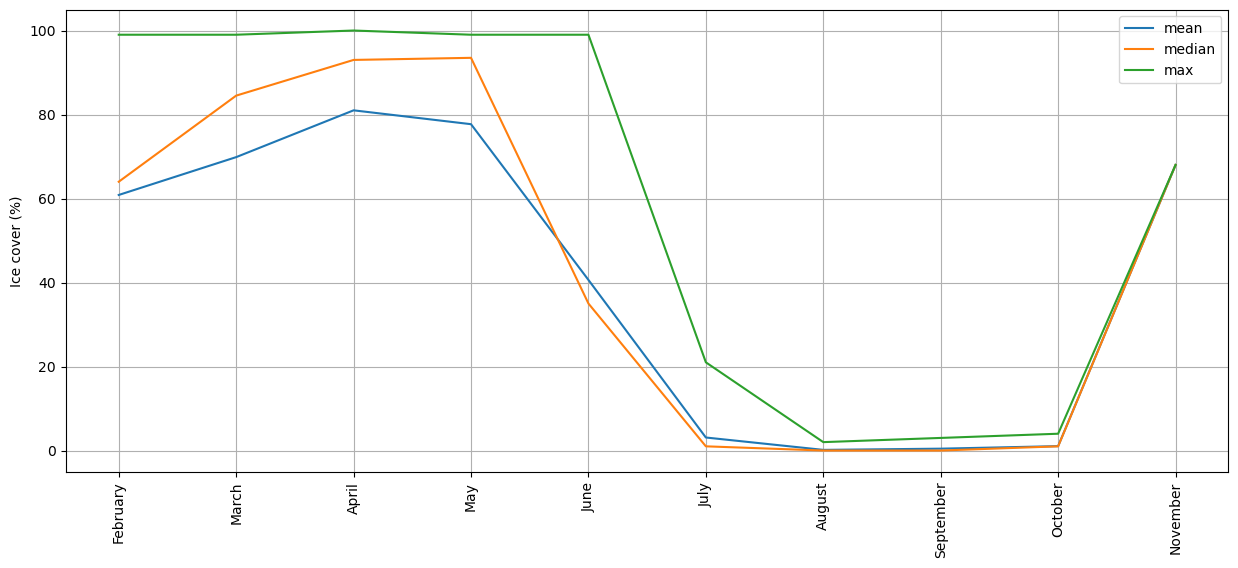

In [14]:
# Examine the seasonal trend of the ice cover by plotting mean, median and max values
plt.figure(figsize=(15, 6))

for i, river_km_id in enumerate(geometries.id.values):
    for stat in ['mean', 'median', 'max']:
        seasonal_stat = clean_arlie[clean_arlie['river_km_id'] == river_km_id].groupby('month')['ice_perc'].agg(stat)
        seasonal_stat = seasonal_stat.sort_index()
        plt.plot(seasonal_stat.index.map(lambda x: calendar.month_name[x]), seasonal_stat.values, linestyle='-', label=f'{stat}')

plt.ylabel('Ice cover (%)')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

The graph above shows how the lake is typically ice-covered until June or July and experiences a freeze once again starting in October.

If we want to dig a bit deeper into the quality of the ice cover observations shown above, we can try to compare the data sources with each other. This is examplified below, where we split all observations by their source and once again, plot the ice cover per month.  

number of Sentinel-1 observations:  0
number of Sentinel-2 observations:  72
number of Sentinel-1+Sentinel-2 observations:  114
s2 avg qc                            mean
source                         
Sentinel-1 Sentinel-2  0.298246
Sentinel-2             0.125000


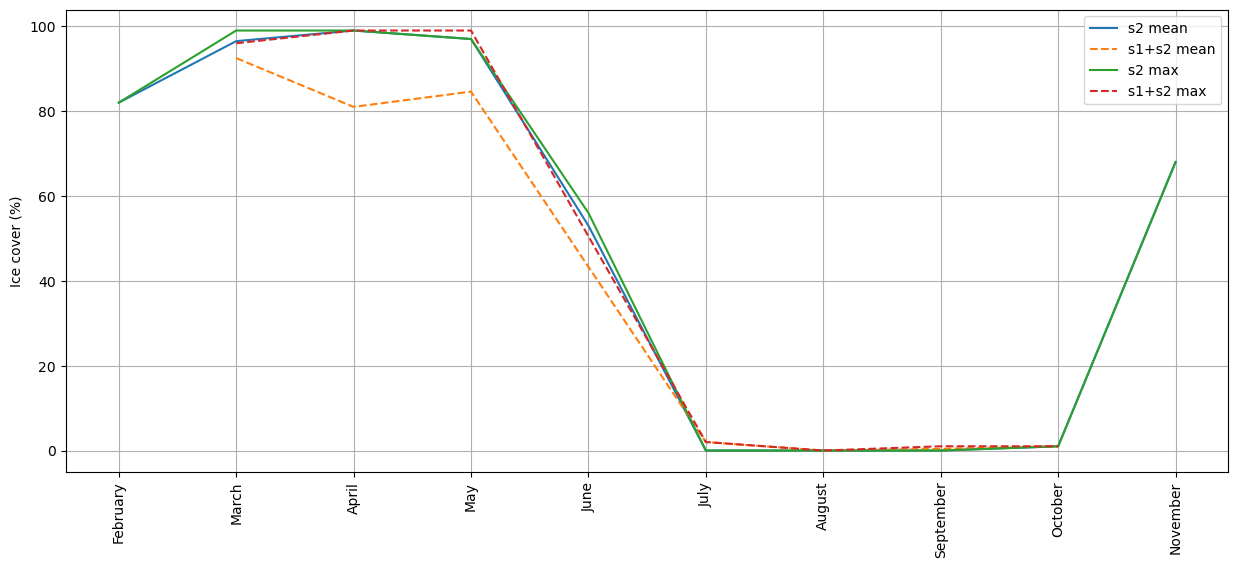

In [17]:
# First separate the clean dataset based on the source (i.e. satellite sensor)
clean_arlie_s1 = clean_arlie[clean_arlie['source'] == 'Sentinel-1']
clean_arlie_s2 = clean_arlie[clean_arlie['source'] == 'Sentinel-2']
clean_arlie_s1s2 = clean_arlie[clean_arlie['source'] == 'Sentinel-1 Sentinel-2']

# we can check how many observations come from each sensor for the AOI
print('number of Sentinel-1 observations: ', len(clean_arlie_s1))
print('number of Sentinel-2 observations: ', len(clean_arlie_s2))
print('number of Sentinel-1+Sentinel-2 observations: ', len(clean_arlie_s1s2))

# none of the S1 observations over the AOI were medium-high confidence
# we can also check whether the S2 or S1+S2 observations tend to have higher confidence
print('s2 avg qc',clean_arlie.groupby('source')['qc'].agg(['mean']))

# the S2 and S1+S2 confidence is fairly similar here on average, but for a different AOI for example, the dataset could be separated by sensor
# we can then examine how similar the S2 vs. S1+S2 observations observations are for 2022
clean_arlie_s2_2022 = clean_arlie_s2[clean_arlie_s2['year'] == 2022]
clean_arlie_s1s2_2022 = clean_arlie_s1s2[clean_arlie_s1s2['year'] == 2022]

# Examine the seasonal trend of the ice cover by satellite source by plotting mean and max values
plt.figure(figsize=(15, 6))

for i, river_km_id in enumerate(geometries.id.values):
    for stat in ['mean', 'max']:
        seasonal_stat_s2 = clean_arlie_s2_2022[clean_arlie_s2_2022['river_km_id'] == river_km_id].groupby('month')['ice_perc'].agg(stat)
        seasonal_stat_s2 = seasonal_stat_s2.sort_index()
        plt.plot(seasonal_stat_s2.index.map(lambda x: calendar.month_name[x]), seasonal_stat_s2.values, linestyle='-', label=f's2 {stat}')
        
        seasonal_stat_s1s2 = clean_arlie_s1s2_2022[clean_arlie_s1s2_2022['river_km_id'] == river_km_id].groupby('month')['ice_perc'].agg(stat)
        seasonal_stat_s1s2 = seasonal_stat_s1s2.sort_index()
        plt.plot(seasonal_stat_s1s2.index.map(lambda x: calendar.month_name[x]), seasonal_stat_s1s2.values, linestyle='--', label=f's1+s2 {stat}')

plt.ylabel('Ice cover (%)')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

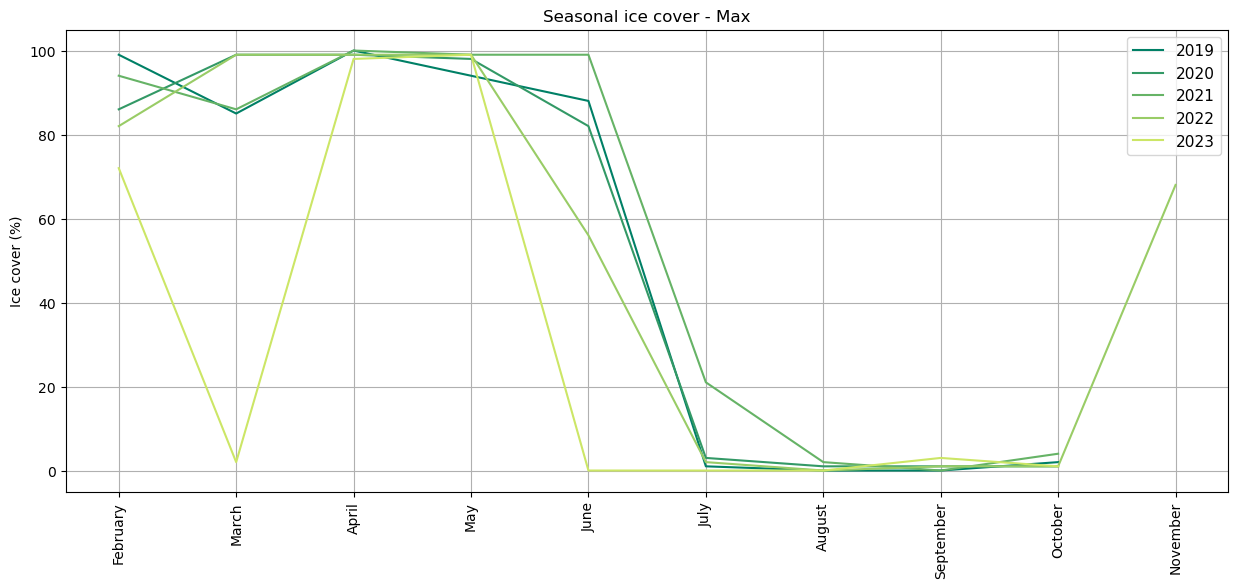

In [15]:
# Finally, instead of looking at averaged data as examplified above, we can also choose to examine individual years

plt.figure(figsize=(15, 6))

years = list(range(2019, 2024))

for i, year in enumerate(years):
    annual_max = clean_arlie[clean_arlie['year'] == year].groupby('month')['ice_perc'].max()
    plt.plot(annual_max.index.map(lambda x: calendar.month_name[x]), annual_max.values, linestyle='-', label=f'{year}', color=plt.cm.summer(i / len(years)))

plt.title('Seasonal ice cover - Max')
plt.xticks(rotation=90)
plt.ylabel('Ice cover (%)')
plt.grid(True)
plt.legend(loc='upper right', fontsize=11, title_fontsize=12)
plt.show()

The graph above shows that most of the years have a realively consistent pattern across most years. However, it also reveals that the year 2023 is different to the other years. The ice cover melts in February and March, deviating from the typical trend observed in other years. This is also what can be seen on the Sentinel-2 images shown at the start of this notebook. Concluding, we can observe the unexpected melting event at lake Öskjuvatn. ❄️🌋